https://github.com/Hukex/Model-Blurfaces Repositorio donde se ejecutan este notebook con todos los datos y modelos generados

# Minor face AI

### Imports

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf

import random
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator

import pandas as pd
import re

from tensorflow.keras.applications import MobileNetV2

import cv2

from statsmodels.stats.proportion import proportion_confint

from IPython.display import display, HTML

### Clasificar y dividir dataset con menores y mayores de edad

In [6]:
dataset_dir = 'archiveFaces/face_age'
output_dir = 'archiveFaces/output'

train_menor_dir = os.path.join(output_dir, 'train', 'menor_de_edad')
val_menor_dir = os.path.join(output_dir, 'val', 'menor_de_edad')
train_mayor_dir = os.path.join(output_dir, 'train', 'mayor_de_edad')
val_mayor_dir = os.path.join(output_dir, 'val', 'mayor_de_edad')
os.makedirs(train_menor_dir, exist_ok=True)
os.makedirs(val_menor_dir, exist_ok=True)
os.makedirs(train_mayor_dir, exist_ok=True)
os.makedirs(val_mayor_dir, exist_ok=True)


def split_and_copy_files(src_dir, train_dir, val_dir, split_ratio=0.2):
    all_files = [os.path.join(src_dir, f) for f in os.listdir(
        src_dir) if os.path.isfile(os.path.join(src_dir, f))]

    if len(all_files) > 1:
        train_files, val_files = train_test_split(
            all_files, test_size=split_ratio, random_state=42)
    else:
        train_files = all_files
        val_files = []

    for file in train_files:
        shutil.copy(file, train_dir)

    for file in val_files:
        shutil.copy(file, val_dir)


for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        age = int(folder)

        if age < 18:
            split_and_copy_files(folder_path, train_menor_dir, val_menor_dir)
        else:
            split_and_copy_files(folder_path, train_mayor_dir, val_mayor_dir)

print("Clasificación y división completadas.")

Clasificación y división completadas.


### Metricas de Specificity y F1Score customs

In [4]:
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred > 0.5, tf.bool)
        self.true_negatives.assign_add(tf.reduce_sum(
            tf.cast(tf.logical_not(y_true) & tf.logical_not(y_pred), tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(
            tf.cast(tf.logical_not(y_true) & y_pred, tf.float32)))

    def result(self):
        specificity = self.true_negatives / \
            (self.true_negatives + self.false_positives)
        return specificity

    def reset_state(self):
        self.true_negatives.assign(0)
        self.false_positives.assign(0)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_state()
        self.recall.reset_state()

### Configuracion para los distintos modelos que se han entrenado

In [5]:
# Configuración
img_height = 200
img_width = 200
num_classes = 1  # Clasificación binaria


def set_seed(seed=5):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)


set_seed(8)

train_dir = 'archiveFaces/output/train'
val_dir = 'archiveFaces/output/val'

# Generadores de datos
train_datagen_original = ImageDataGenerator(rescale=1./255)

train_datagen_transform_1 = ImageDataGenerator(  # Transformación 1
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen_transform_2 = ImageDataGenerator(  # Transformación 2
    rescale=1./255,  # Normalizar los píxeles al rango [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator_original = train_datagen_original.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

train_generator_transform_1 = train_datagen_transform_1.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

train_generator_transform_2 = train_datagen_transform_2.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary'
)


def load_history(model_name):
    return np.load(f"{model_name}_history.npy", allow_pickle=True).item()


def plot_metrics(axes, history, title):
    # Graficar pérdida
    loss_entrenamiento = round(history['loss'][-1], 2)
    loss_validacion = round(history['val_loss'][-1], 2)
    axes.plot(history['loss'], linestyle="dotted",
              label=f"Pérdida entrenamiento: {loss_entrenamiento}", c="#003B80")
    axes.plot(history['val_loss'], linestyle="solid",
              label=f"Pérdida validación: {loss_validacion}", c="#003B80")

    # Graficar otras métricas
    metrics = ['accuracy', 'precision', 'recall', 'specificity', 'auc']
    colors = ['#007ACC', '#00CC74', '#FFD700', '#FF6347', '#4682B4']

    for metric, color in zip(metrics, colors):

        metric_keys = [key for key in history.keys(
        ) if re.match(rf'{metric}(?:_\d+)?', key)]
        val_metric_keys = [key for key in history.keys(
        ) if re.match(rf'val_{metric}(?:_\d+)?', key)]

        if metric_keys and val_metric_keys:
            metric_entrenamiento = round(history[metric_keys[0]][-1], 2)
            metric_validacion = round(history[val_metric_keys[0]][-1], 2)
            axes.plot(history[metric_keys[0]], linestyle="dotted",
                      label=f"{metric.capitalize()} entrenamiento: {metric_entrenamiento}", c=color)
            axes.plot(history[val_metric_keys[0]], linestyle="solid",
                      label=f"{metric.capitalize()} validación: {metric_validacion}", c=color)

    # Configuración de los ejes y la gráfica
    axes.set_xlabel('Nº Épocas', fontsize=13, color="#003B80")
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    axes.set_ylabel('Métricas', fontsize=13, color="#003B80")
    axes.set_ylim(ymin=0, ymax=1.1)
    axes.yaxis.set_major_locator(MultipleLocator(0.1))
    axes.set_title(title)
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both',
              color="#FFFFFF", linewidth=2)
    axes.legend()


def recopilar_resultados(model_names):
    results = []

    for model_name in model_names:
        history = load_history(model_name)
        if history:
            last_epoch = len(history['val_loss']) - 1
            result = {
                'Modelo': model_name,
                'Pérdida de Validación': history['val_loss'][last_epoch],
                'Precisión de Validación': history['val_accuracy'][last_epoch]
            }

            recall_keys = [key for key in history.keys(
            ) if re.match(r'val_recall(?:_\d+)?', key)]
            precision_keys = [key for key in history.keys(
            ) if re.match(r'val_precision(?:_\d+)?', key)]
            specificity_keys = [key for key in history.keys(
            ) if re.match(r'val_specificity(?:_\d+)?', key)]

            if recall_keys:
                result['Sensibilidad de Validación'] = history[recall_keys[0]][last_epoch]
            else:
                result['Sensibilidad de Validación'] = None

            if precision_keys:
                result['Precisión de Validación'] = history[precision_keys[0]][last_epoch]
            else:
                result['Precisión de Validación'] = None

            if specificity_keys:
                result['Especificidad de Validación'] = history[specificity_keys[0]][last_epoch]
            else:
                result['Especificidad de Validación'] = None

            results.append(result)

    # Convertir los resultados en un DataFrame para fácil manipulación y visualización
    df_results = pd.DataFrame(results)
    df_results.sort_values(by='Pérdida de Validación',
                           ascending=True, inplace=True)
    return df_results

Found 7780 images belonging to 2 classes.
Found 7780 images belonging to 2 classes.
Found 7780 images belonging to 2 classes.
Found 1998 images belonging to 2 classes.


### Método para el model, en los modelos iniciales hubo un error y no le pase las métricas necesarias

In [10]:
def create_model(learning_rate, use_batch_norm):
    inputs = Input(shape=(img_height, img_width, 3))
    x = inputs

    # 1er bloque convolucional
    for filters in [32, 64, 128, 256]:
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    # Capa densa oculta
    x = Dense(32, activation='relu')(x)
    if use_batch_norm:
        x = BatchNormalization()(x)

    # Capa de salida
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Crear modelo
    model = Model(inputs=inputs, outputs=outputs)

    # Compilar modelo
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            Specificity(),
            F1Score(),
            AUC(name='auc'),
            TruePositives(name='true_positives'),
            TrueNegatives(name='true_negatives'),
            FalsePositives(name='false_positives'),
            FalseNegatives(name='false_negatives')
        ]
    )
    return model

In [11]:
def entrenar_modelos(epochs, learning_rates, batch_sizes, batch_norm_options, train_generator, val_generator, early_stopping, reduce_lr, model_checkpoint=None):
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for use_batch_norm in batch_norm_options:
                model_name = f"model_lr_{lr}_batch_{batch_size}_batchnorm_{use_batch_norm}_epochs_{epochs}"
                model_path = f"{model_name}.h5"
                history_path = f"{model_name}_history.npy"

                if os.path.exists(model_path) and os.path.exists(history_path):
                    print(f"{model_name} ya existe. Saltando entrenamiento.")
                    continue

                print(f"Entrenando {model_name}...")

                model = create_model(lr, use_batch_norm)
                train_generator.batch_size = batch_size
                val_generator.batch_size = batch_size

                callbacks = [early_stopping, reduce_lr]
                if model_checkpoint:
                    callbacks.append(model_checkpoint)

                history = model.fit(
                    train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=callbacks
                )

                # Guardar el modelo entrenado
                model.save(model_path)

                # Guardar el historial de entrenamiento
                np.save(history_path, history.history)

                print(f"{model_name} entrenado y guardado.")

    print("Entrenamiento completado.")

In [ ]:
# Parámetros para probar
learning_rates = [0.01, 0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
batch_norm_options = [True, False]

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

entrenar_modelos(150, learning_rates, batch_sizes, batch_norm_options,
                 train_generator_transform_1, val_generator, early_stopping, reduce_lr)

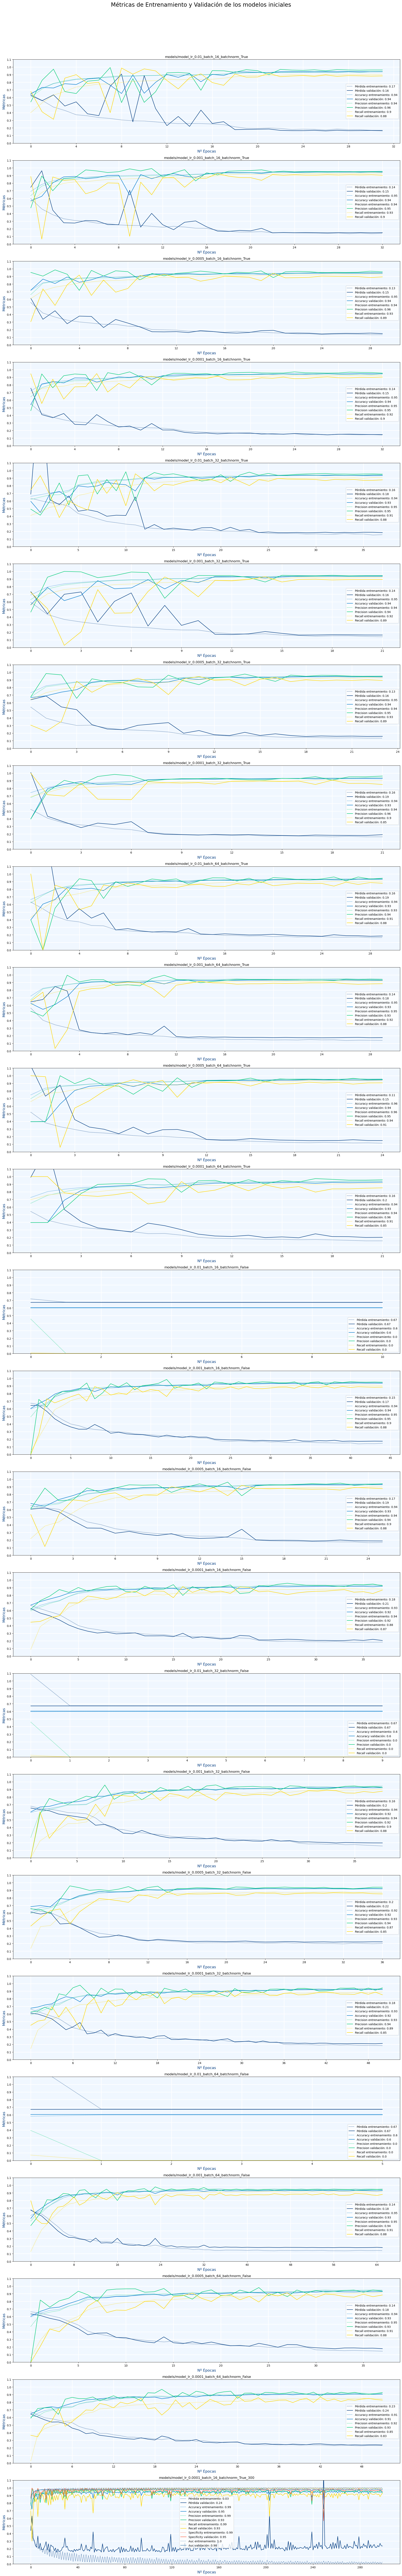

In [11]:
model_names = [
    "models/model_lr_0.01_batch_16_batchnorm_True",
    "models/model_lr_0.001_batch_16_batchnorm_True",
    "models/model_lr_0.0005_batch_16_batchnorm_True",
    "models/model_lr_0.0001_batch_16_batchnorm_True",
    "models/model_lr_0.01_batch_32_batchnorm_True",
    "models/model_lr_0.001_batch_32_batchnorm_True",
    "models/model_lr_0.0005_batch_32_batchnorm_True",
    "models/model_lr_0.0001_batch_32_batchnorm_True",
    "models/model_lr_0.01_batch_64_batchnorm_True",
    "models/model_lr_0.001_batch_64_batchnorm_True",
    "models/model_lr_0.0005_batch_64_batchnorm_True",
    "models/model_lr_0.0001_batch_64_batchnorm_True",
    "models/model_lr_0.01_batch_16_batchnorm_False",
    "models/model_lr_0.001_batch_16_batchnorm_False",
    "models/model_lr_0.0005_batch_16_batchnorm_False",
    "models/model_lr_0.0001_batch_16_batchnorm_False",
    "models/model_lr_0.01_batch_32_batchnorm_False",
    "models/model_lr_0.001_batch_32_batchnorm_False",
    "models/model_lr_0.0005_batch_32_batchnorm_False",
    "models/model_lr_0.0001_batch_32_batchnorm_False",
    "models/model_lr_0.01_batch_64_batchnorm_False",
    "models/model_lr_0.001_batch_64_batchnorm_False",
    "models/model_lr_0.0005_batch_64_batchnorm_False",
    "models/model_lr_0.0001_batch_64_batchnorm_False",
    "models/model_lr_0.0001_batch_16_batchnorm_True_300" # Se alterno usando imagenes de entrenamiento originales en 1 epoca y luego en otra epoca usando transformadas
]


histories = [load_history(model_name) for model_name in model_names if os.path.exists(
    f"{model_name}_history.npy")]

# Graficar las métricas de todos los modelos
figure = plt.figure(figsize=(20, 5 * len(histories)))
index = 1

for history, model_name in zip(histories, model_names):
    axes = figure.add_subplot(len(histories), 1, index)
    plot_metrics(axes, history, model_name)
    index += 1

plt.tight_layout()
plt.suptitle(
    'Métricas de Entrenamiento y Validación de los modelos iniciales', y=1.02, fontsize=20)
plt.show()

In [9]:
recopilar_resultados(model_names)

Modelo  Pérdida de Validación  \
3      models/model_lr_0.0001_batch_16_batchnorm_True               0.146844   
10     models/model_lr_0.0005_batch_64_batchnorm_True               0.147781   
2      models/model_lr_0.0005_batch_16_batchnorm_True               0.148178   
1       models/model_lr_0.001_batch_16_batchnorm_True               0.148910   
6      models/model_lr_0.0005_batch_32_batchnorm_True               0.157611   
0        models/model_lr_0.01_batch_16_batchnorm_True               0.163113   
5       models/model_lr_0.001_batch_32_batchnorm_True               0.163572   
13     models/model_lr_0.001_batch_16_batchnorm_False               0.173345   
9       models/model_lr_0.001_batch_64_batchnorm_True               0.175232   
22    models/model_lr_0.0005_batch_64_batchnorm_False               0.177920   
21     models/model_lr_0.001_batch_64_batchnorm_False               0.181266   
4        models/model_lr_0.01_batch_32_batchnorm_True               0.183631   
8        models/model_lr_0.01_batch_64_batchnorm_True               0.185154   
14    models/model_lr_0.0005_batch_16_batchnorm_False               0.188123   
7      models/model_lr_0.0001_batch_32_batchnorm_True               0.191259   
17     models/model_lr_0.001_batch_32_batchnorm_False               0.196416   
11     models/model_lr_0.0001_batch_64_batchnorm_True               0.201510   
15    models/model_lr_0.0001_batch_16_batchnorm_False               0.205377   
19    models/model_lr_0.0001_batch_32_batchnorm_False               0.212198   
18    models/model_lr_0.0005_batch_32_batchnorm_False               0.222323   
24  models/model_lr_0.0001_batch_16_batchnorm_True...               0.235883   
23    models/model_lr_0.0001_batch_64_batchnorm_False               0.237825   
12      models/model_lr_0.01_batch_16_batchnorm_False               0.671362   
16      models/model_lr_0.01_batch_32_batchnorm_False               0.671501   
20      models/model_lr_0.01_batch_64_batchnorm_False               0.671564   

    Precisión de Validación  Sensibilidad de Validación  \
3                  0.954545                    0.902655   
10                 0.952191                    0.906448   
2                  0.959294                    0.893805   
1                  0.954606                    0.903919   
6                  0.948925                    0.892541   
0                  0.961486                    0.883692   
5                  0.942667                    0.893805   
13                 0.948510                    0.884956   
9                  0.934492                    0.883692   
22                 0.933244                    0.883692   
21                 0.940541                    0.879899   
4                  0.951989                    0.877370   
8                  0.944293                    0.878635   
14                 0.940298                    0.876106   
7                  0.961429                    0.850822   
17                 0.924000                    0.876106   
11                 0.957386                    0.852086   
15                 0.924630                    0.868521   
19                 0.942657                    0.852086   
18                 0.940028                    0.852086   
24                 0.930556                    0.931732   
23                 0.926450                    0.828066   
12                 0.000000                    0.000000   
16                 0.000000                    0.000000   
20                 0.000000                    0.000000   

    Especificidad de Validación  
3                           NaN  
10                          NaN  
2                           NaN  
1                           NaN  
6                           NaN  
0                           NaN  
5                           NaN  
13                          NaN  
9                           NaN  
22                          NaN  
21                          NaN  
4                      

En base a las graficas y al resultado que nos arroja el dataset con los distintos datos hemos optado por quedarnos con el modelo *model_lr_0.0001_batch_16_batchnorm_True*

El cual se ha reentrenado 3 veces con mas epocas para que se ajustara mejor a los datos del dataset y se ha optado por aplicar 2 tipos de transformaciones y 1 con los fotos originales por ver cual se desempeñaba mejor

In [ ]:
learning_rates = [0.0001]
batch_sizes = [16]
batch_norm_options = [True]


early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    'mejor_modelo.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

entrenar_modelos(150, learning_rates, batch_sizes, batch_norm_options,
                 train_generator_transform_1, val_generator, early_stopping, reduce_lr, model_checkpoint)

In [ ]:
learning_rates = [0.0001]
batch_sizes = [16]
batch_norm_options = [True]


early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    'mejor_modelo.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

entrenar_modelos(150, learning_rates, batch_sizes, batch_norm_options,
                 train_generator_transform_2, val_generator, early_stopping, reduce_lr, model_checkpoint)

In [ ]:
learning_rates = [0.0001]
batch_sizes = [16]
batch_norm_options = [True]


early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(
    'mejor_modelo.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

entrenar_modelos(150, learning_rates, batch_sizes, batch_norm_options,
                 train_generator_original, val_generator, early_stopping, reduce_lr, model_checkpoint)

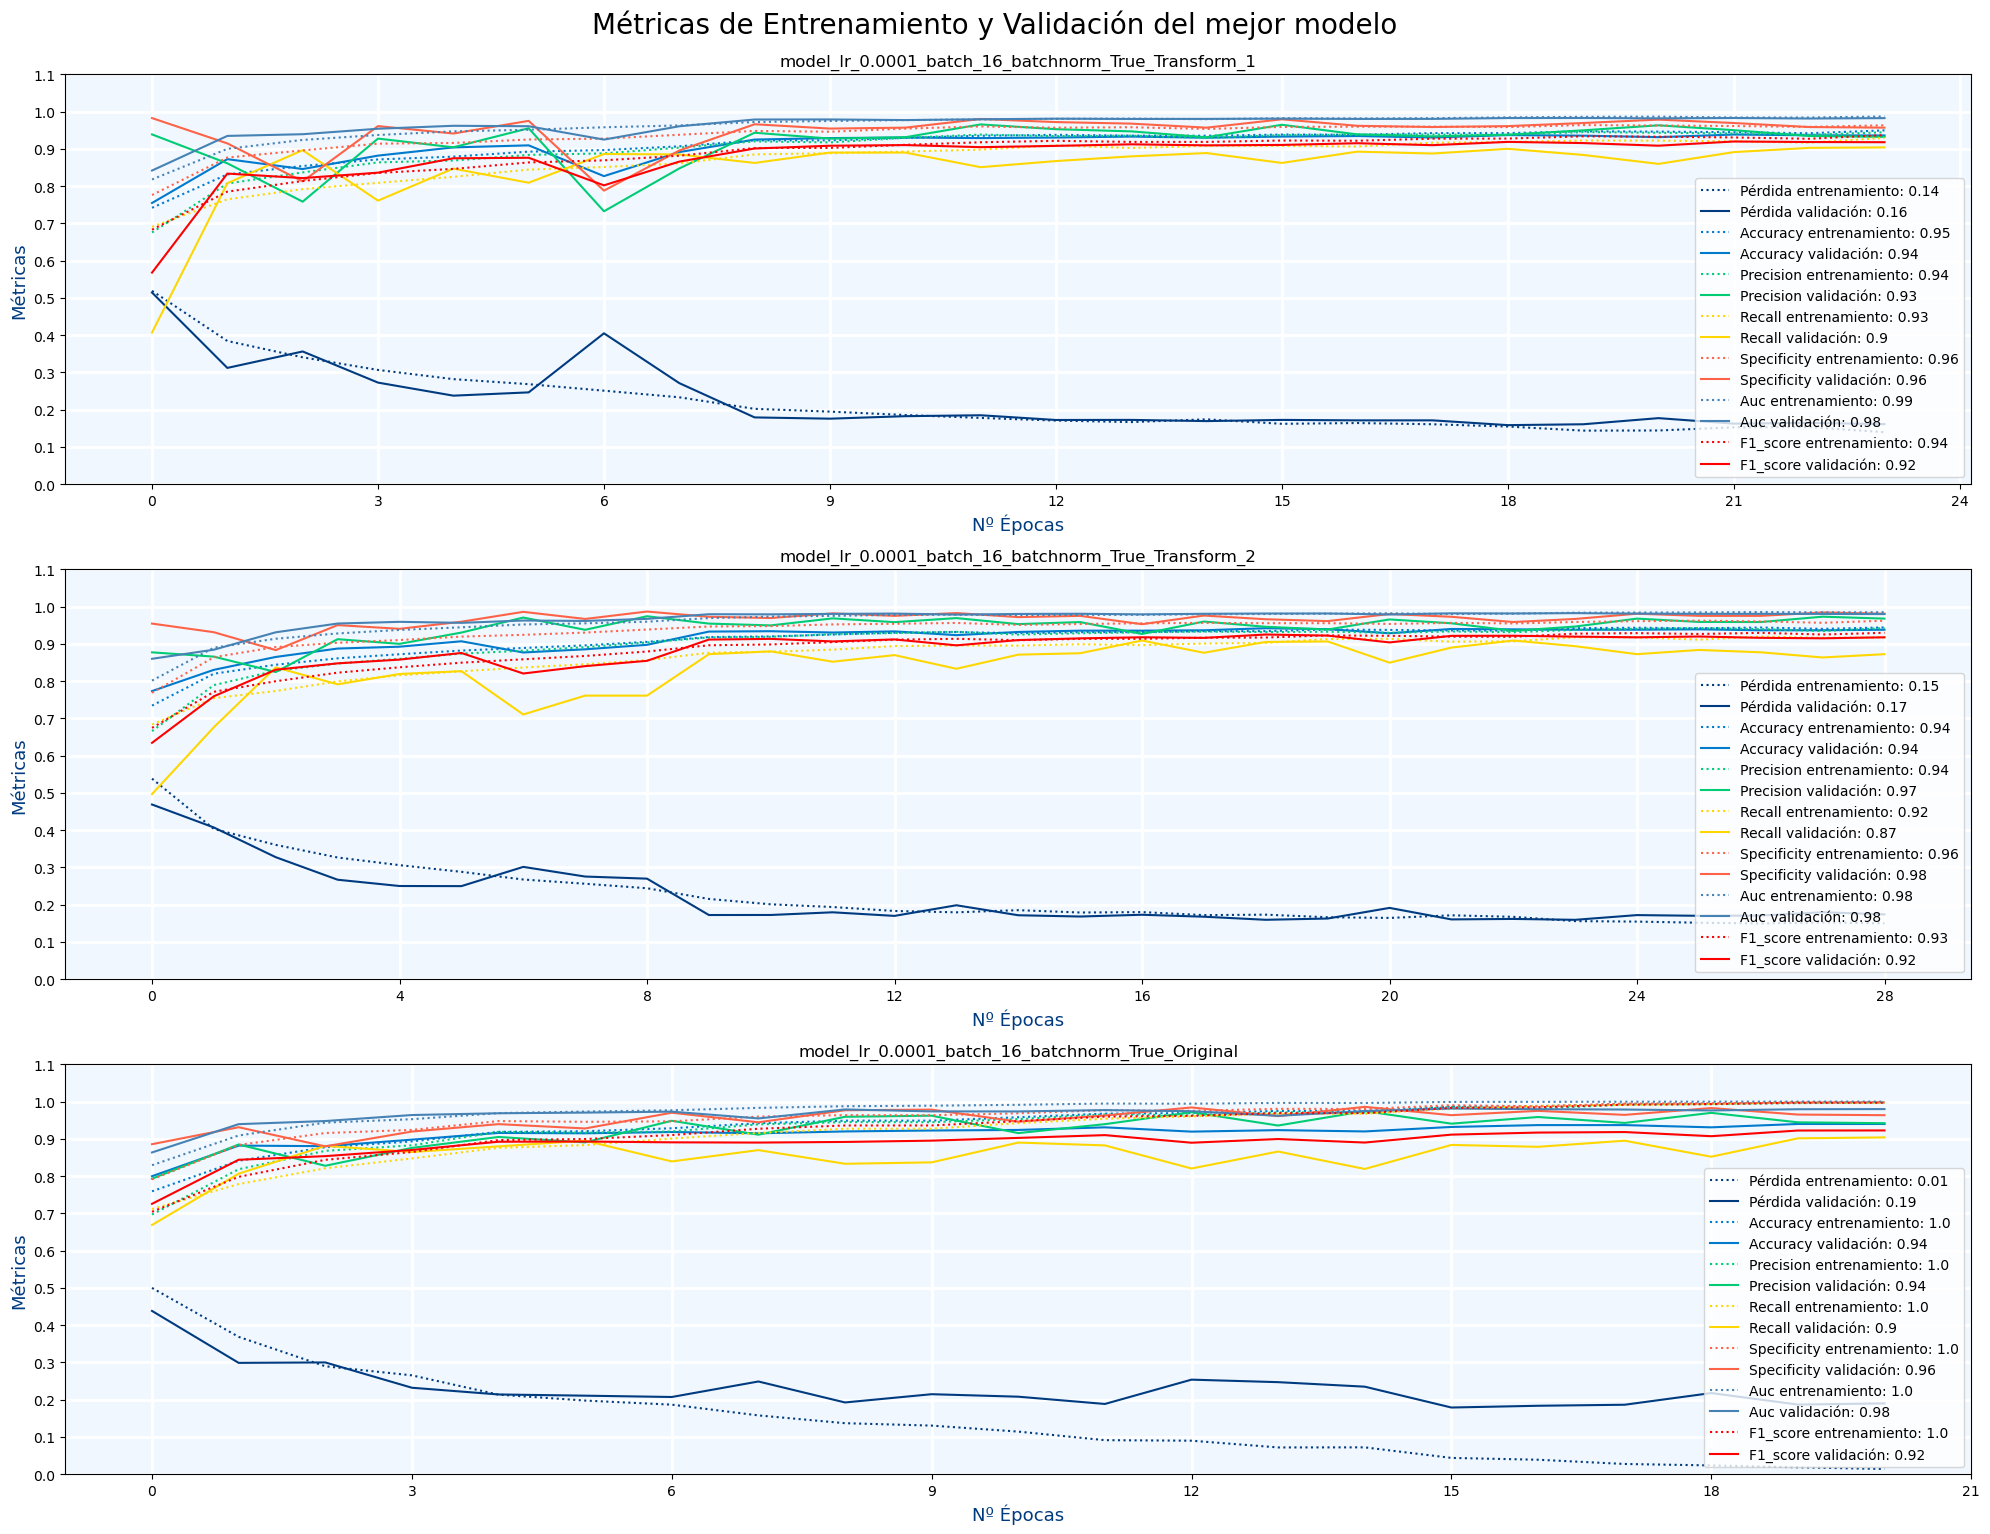

In [8]:
model_names = [
    "model_lr_0.0001_batch_16_batchnorm_True_Transform_1",
    "model_lr_0.0001_batch_16_batchnorm_True_Transform_2",
    "model_lr_0.0001_batch_16_batchnorm_True_Original"
]

histories = [load_history(model_name) for model_name in model_names if os.path.exists(
    f"{model_name}_history.npy")]

figure = plt.figure(figsize=(20, 5 * len(histories)))
index = 1

for history, model_name in zip(histories, model_names):
    axes = figure.add_subplot(len(histories), 1, index)
    plot_metrics(axes, history, model_name)
    index += 1

plt.tight_layout()
plt.suptitle(
    'Métricas de Entrenamiento y Validación del mejor modelo', y=1.02, fontsize=20)
plt.show()

In [ ]:
recopilar_resultados(model_names)

Modelo  Pérdida de Validación  \
0  model_lr_0.0001_batch_16_batchnorm_True_Transf...               0.161209   
1  model_lr_0.0001_batch_16_batchnorm_True_Transf...               0.173967   
2   model_lr_0.0001_batch_16_batchnorm_True_Original               0.190129   

   Precisión de Validación  Sensibilidad de Validación  \
0                 0.932203                    0.903919   
1                 0.967742                    0.872313   
2                 0.942029                    0.903919   

   Especificidad de Validación  
0                     0.956918  
1                     0.980945  
2                     0.963546

Entre los 3 modelos vemos que el mejor seria el que se aplica la transformacion 1 asi que optamos por escoger ese para compararlo a posteriori vs los de mobilenetv2

In [23]:
def entrenar_modelo_con_mobilenetv2(train_generator, epochs_feature_extraction, epochs_fine_tuning):
    base_model = MobileNetV2(
        weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    # Añadir capas personalizadas
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        Specificity(),
        F1Score(),
        AUC(name='auc'),
        TruePositives(name='true_positives'),
        TrueNegatives(name='true_negatives'),
        FalsePositives(name='false_positives'),
        FalseNegatives(name='false_negatives')
    ])

    # Definir callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    # Entrenamiento para la extracción de características
    print("Iniciando la extracción de características...")
    history_feature_extraction = model.fit(
        train_generator,
        epochs=epochs_feature_extraction,
        validation_data=val_generator
    )

    # Guardar el historial de la extracción de características
    np.save(f'{epochs_feature_extraction}_{epochs_fine_tuning}_feature_extraction_history.npy',
            history_feature_extraction.history)

    # Descongelar algunas capas superiores del modelo base para el ajuste fino
    for layer in base_model.layers[-100:]:
        layer.trainable = True

    # Recompilar el modelo para el ajuste fino
    model.compile(optimizer=Adam(learning_rate=0.00001),
                  loss='binary_crossentropy',
                  metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        Specificity(),
        F1Score(),
        AUC(name='auc'),
        TruePositives(name='true_positives'),
        TrueNegatives(name='true_negatives'),
        FalsePositives(name='false_positives'),
        FalseNegatives(name='false_negatives')
    ])

    # Entrenamiento para el ajuste fino
    print("Iniciando el ajuste fino...")
    history_fine_tuning = model.fit(
        train_generator,
        epochs=epochs_fine_tuning,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # Guardar el historial del ajuste fino
    np.save(f'{epochs_feature_extraction}_{epochs_fine_tuning}_fine_tuning_history.npy',
            history_fine_tuning.history)

    # Guardar el modelo ajustado
    model.save(f'{epochs_feature_extraction}_{epochs_fine_tuning}_ajustado.h5')

    print("Modelo entrenado y guardado con éxito.")

In [ ]:
entrenar_modelo_con_mobilenetv2(
    train_generator_transform_1, epochs_feature_extraction=10, epochs_fine_tuning=20)

In [ ]:
entrenar_modelo_con_mobilenetv2(
    train_generator_transform_1, epochs_feature_extraction=15, epochs_fine_tuning=20)

In [ ]:
entrenar_modelo_con_mobilenetv2(
    train_generator_transform_1, epochs_feature_extraction=20, epochs_fine_tuning=20)

Optamos por entrenar 3 modelos basados en mobilenetv2, variando las epocas de extracción de características

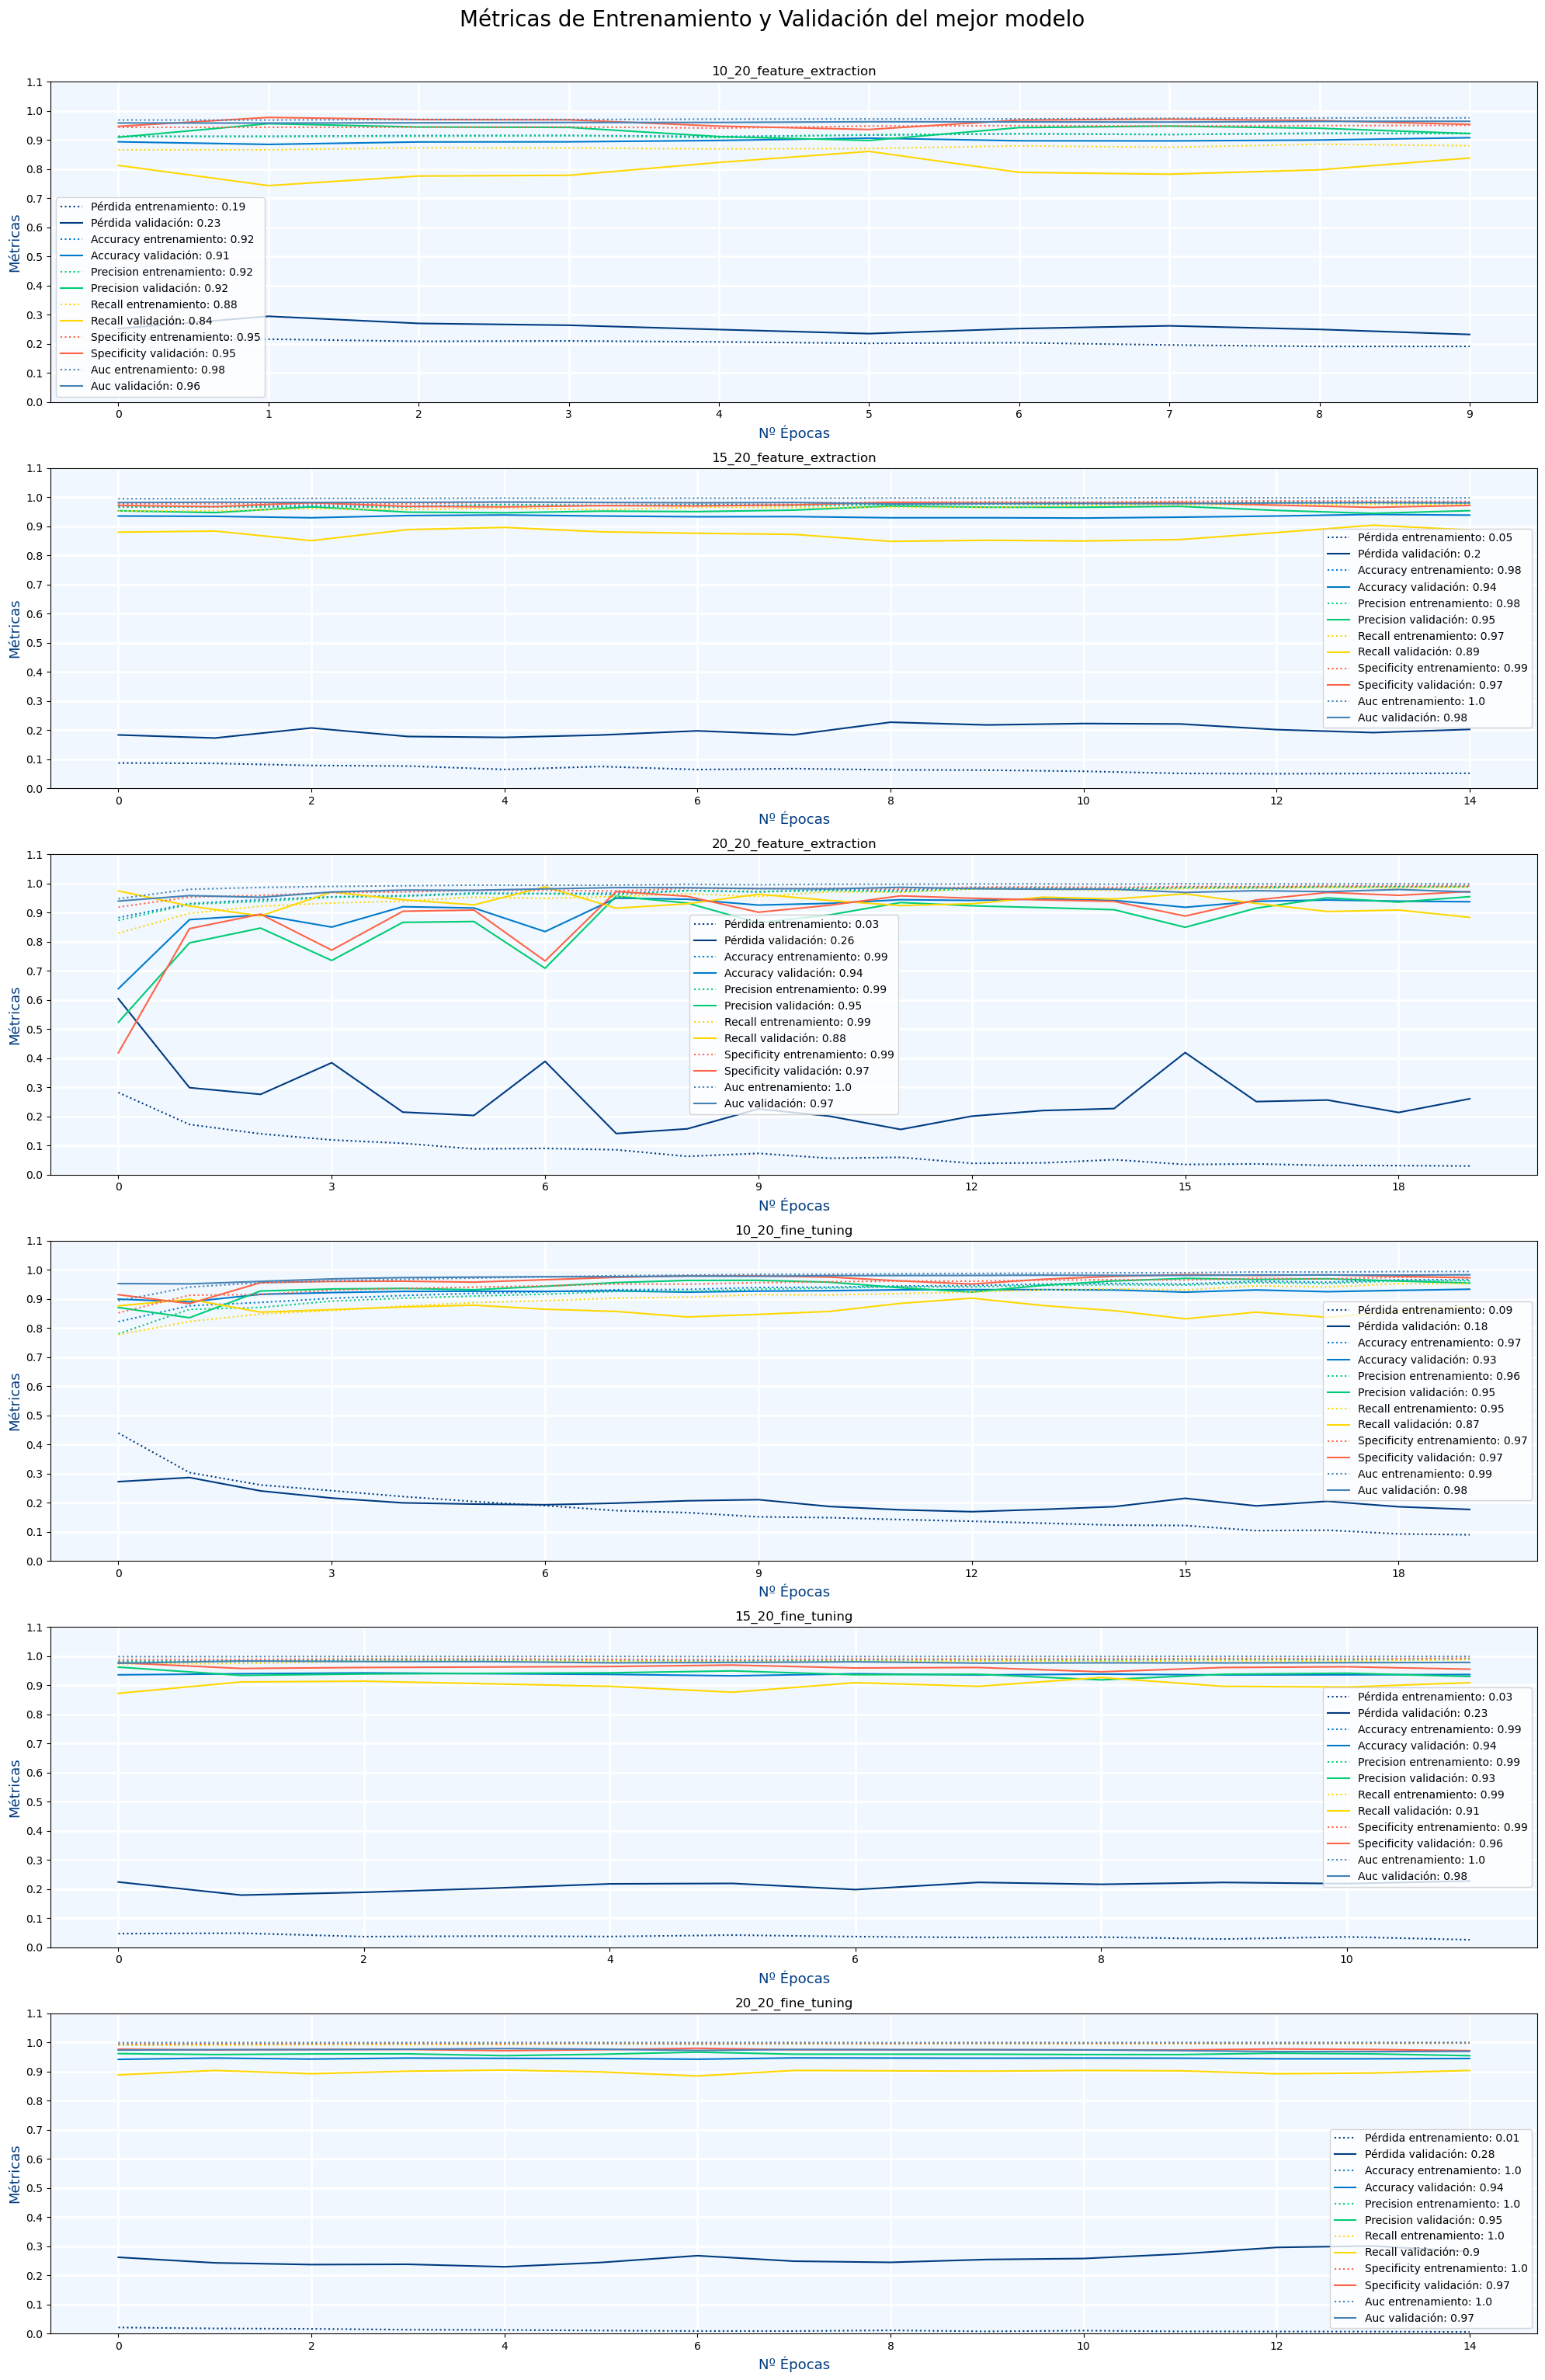

In [24]:
model_names = [
    "10_20_feature_extraction",
    "15_20_feature_extraction",
    "20_20_feature_extraction",
    "10_20_fine_tuning",
    "15_20_fine_tuning",
    "20_20_fine_tuning"
]

histories = [load_history(model_name) for model_name in model_names if os.path.exists(
    f"{model_name}_history.npy")]

figure = plt.figure(figsize=(20, 5 * len(histories)))
index = 1

for history, model_name in zip(histories, model_names):
    axes = figure.add_subplot(len(histories), 1, index)
    plot_metrics(axes, history, model_name)
    index += 1

plt.tight_layout()
plt.suptitle(
    'Métricas de Entrenamiento y Validación del mejor modelo', y=1.02, fontsize=20)
plt.show()

In [25]:
recopilar_resultados(model_names)

Modelo  Pérdida de Validación  Precisión de Validación  \
3         10_20_fine_tuning               0.176935                 0.954420   
1  15_20_feature_extraction               0.202483                 0.953804   
4         15_20_fine_tuning               0.227806                 0.930142   
0  10_20_feature_extraction               0.232044                 0.922114   
2  20_20_feature_extraction               0.260595                 0.954918   
5         20_20_fine_tuning               0.281645                 0.954606   

   Sensibilidad de Validación  Especificidad de Validación  
3                    0.873578                     0.972659  
1                    0.887484                     0.971831  
4                    0.908976                     0.955261  
0                    0.838180                     0.953604  
2                    0.883692                     0.972659  
5                    0.903919                     0.971831

In [249]:
def calculate_metrics(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    return thresholds, precision, recall


def load_images(image_paths):
    images = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is not None:
            if img.max() > 1:
                img = img.astype('float32') / 255.0
            images.append(img)
        else:
            print(f"Error al cargar la imagen: {image_path}")
    return np.array(images)


# Construir la lista de rutas de imágenes
image_paths = []
folders = ["foto_preprocessed", "foto2_preprocessed", "foto3_preprocessed", "foto4_preprocessed",
           "foto5_preprocessed", "foto6_preprocessed", "foto7_preprocessed", "foto8_preprocessed"]

for folder in folders:
    full_path = os.path.join(folder)  # Ajustar la ruta base a "/"
    if os.path.exists(full_path):
        for file in os.listdir(full_path):
            if file.endswith(".png"):
                image_paths.append(os.path.join(full_path, file))

# Cargar las imágenes
loaded_imgs = load_images(image_paths)


def evaluar_modelo(model_name, loaded_imgs, y_true):
    classification_model = tf.keras.models.load_model(f"{model_name}.h5", custom_objects={
        'Specificity': Specificity,
        'F1Score': F1Score
    })

    predictions = classification_model.predict(loaded_imgs)

    thresholds, precision, recall = calculate_metrics(
        y_true, predictions.flatten())

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Umbral')
    plt.ylabel('Valor')
    plt.title(
        f'Precisión y Sensibilidad para Diferentes Umbrales\n{model_name}')
    plt.legend()
    plt.grid(True)

    plt.show()


# Son las fotos recortadas del BlurFaces.ipynb, 1 menor 0 mayor
y_true = [1, 1, 0, 0, 0,  # Foto1
          0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,  # Foto2
          0, 1, 0, 0, 0, 0, 1, 0,  # Foto3
          0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,  # Foto4
          1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,  # Foto5
          1, 1, 1, 0, 1, 1,  # Foto6
          0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,  # Foto7
          1, 0, 1, 0, 0, 0, 0, 1, 0, 1  # Foto 8
          ]

3/3 [==============================] - 2s 955ms/step


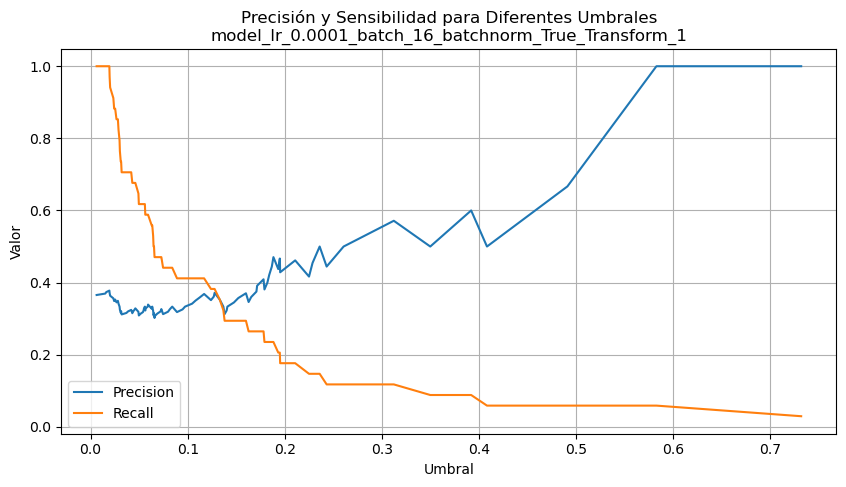

In [250]:
evaluar_modelo(
    "model_lr_0.0001_batch_16_batchnorm_True_Transform_1", loaded_imgs, y_true)

3/3 [==============================] - 2s 459ms/step


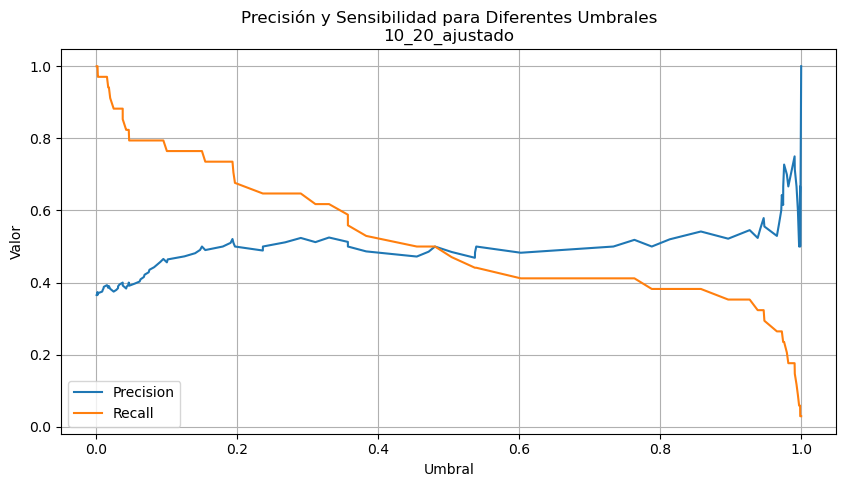

In [251]:
evaluar_modelo("10_20_ajustado", loaded_imgs, y_true)

3/3 [==============================] - 1s 334ms/step


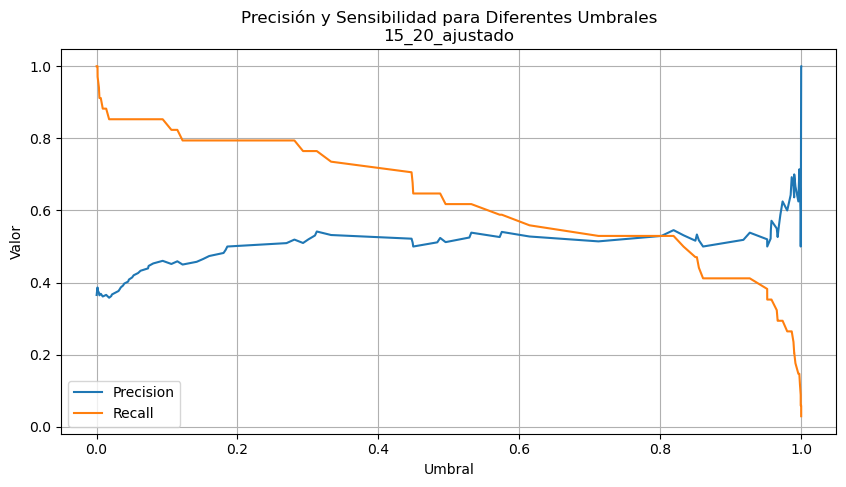

In [252]:
evaluar_modelo("15_20_ajustado", loaded_imgs, y_true)

3/3 [==============================] - 1s 433ms/step


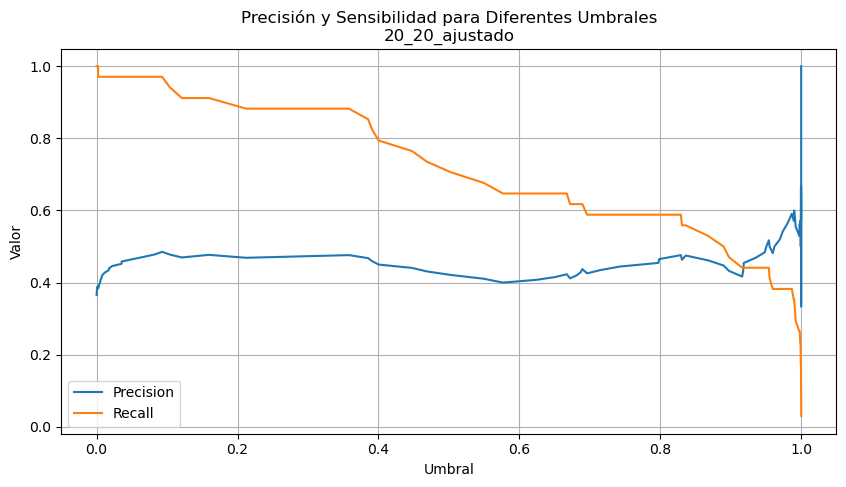

In [253]:
evaluar_modelo("20_20_ajustado", loaded_imgs, y_true)

El umbral óptimo identificado es de 0.4 para los tres modelos evaluados basados en MobileNetV2, y de 0.2 para nuestro modelo desarrollado sin transferencia de conocimientos. Estos valores se seleccionan porque proporcionan un equilibrio donde la sensibilidad (recall) es alta, lo cual es crucial para nuestro objetivo de censurar imágenes de menores de edad. A estos umbrales, la sensibilidad se mantiene en un nivel alto, asegurando que la mayoría de los menores sean detectados y censurados. Aunque esto pueda resultar en la censura de algunos adultos, es un compromiso aceptable dado el contexto de uso del modelo, donde es preferible evitar la exposición de menores a toda costa.

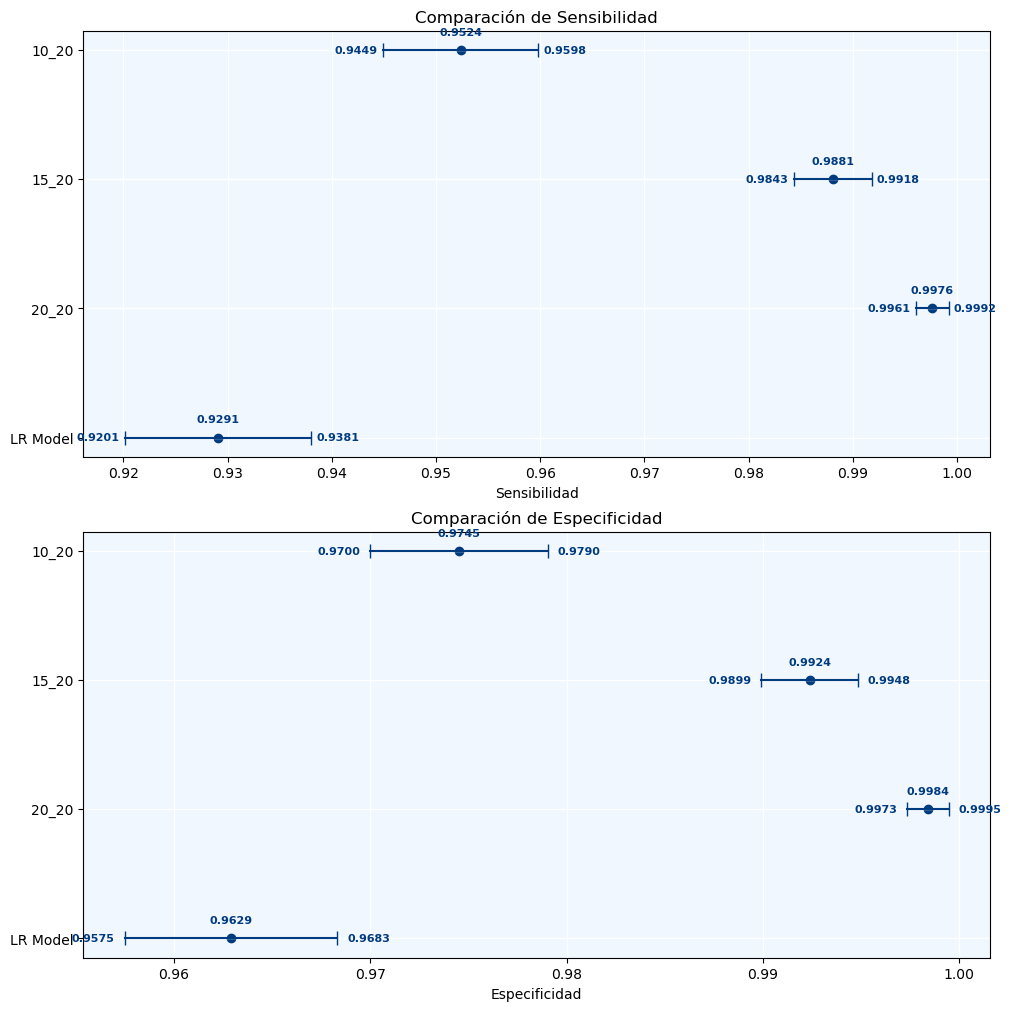

In [55]:
def plot_intervals(axes, intervalos, title, xlabel, ylabels):
    for index, (inferior, superior) in enumerate(intervalos):
        position = len(intervalos) - index - 1
        media = ((superior - inferior) / 2) + inferior
        axes.plot([inferior, superior], [position, position],
                  marker='|', markersize=10, linestyle='-', color='#003B80')
        axes.scatter(media, position, color='#003B80')
        margin = 0.0005
        axes.text(superior + margin, position, f'{superior:.4f}', verticalalignment='center',
                  horizontalalignment='left', color='#003B80', fontsize=8, fontweight='bold')
        axes.text(inferior - margin, position, f'{inferior:.4f}', verticalalignment='center',
                  horizontalalignment='right', color='#003B80', fontsize=8, fontweight='bold')
        # Añadir texto para el punto medio
        axes.text(media, position + 0.1, f'{media:.4f}', verticalalignment='bottom',
                  horizontalalignment='center', color='#003B80', fontsize=8, fontweight='bold')
    axes.set_yticks(np.arange(len(ylabels)))
    axes.set_yticklabels(ylabels[::-1])
    axes.set_xlabel(xlabel)
    axes.set_title(title)
    axes.set_facecolor("#F0F7FF")
    axes.grid(visible=True, which='major', axis='both',
              color="#FFFFFF", linewidth=1)


fine_tuning_history_20_20 = np.load(
    '20_20_fine_tuning_history.npy', allow_pickle=True).item()
fine_tuning_history_10_20 = np.load(
    '10_20_fine_tuning_history.npy', allow_pickle=True).item()
fine_tuning_history_15_20 = np.load(
    '15_20_fine_tuning_history.npy', allow_pickle=True).item()
transform_1_model_lr = np.load(
    'model_lr_0.0001_batch_16_batchnorm_True_Transform_1_history.npy', allow_pickle=True).item()

modelos_datos = {
    '10_20': fine_tuning_history_10_20,
    '15_20': fine_tuning_history_15_20,
    '20_20': fine_tuning_history_20_20,
    'LR Model': transform_1_model_lr
}

confianza = 95
method = 'jeffreys'

intervalos_sens = []
intervalos_esp = []
ylabels = []

for modelo, datos in modelos_datos.items():
    verdaderos_positivos = datos['true_positives'][-1]
    verdaderos_negativos = datos['true_negatives'][-1]
    falsos_negativos = datos['false_negatives'][-1]
    falsos_positivos = datos['false_positives'][-1]

    total_positivos = verdaderos_positivos + falsos_negativos
    total_negativos = verdaderos_negativos + falsos_positivos

    lower_sens, upper_sens = proportion_confint(
        verdaderos_positivos, total_positivos, alpha=1-(confianza/100), method=method)
    lower_esp, upper_esp = proportion_confint(
        verdaderos_negativos, total_negativos, alpha=1-(confianza/100), method=method)

    intervalos_sens.append((lower_sens, upper_sens))
    intervalos_esp.append((lower_esp, upper_esp))
    ylabels.append(modelo)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), constrained_layout=True)

# Usar plot_intervals para Sensibilidad y Especificidad
plot_intervals(ax1, intervalos_sens,
               'Comparación de Sensibilidad', 'Sensibilidad', ylabels)
plot_intervals(ax2, intervalos_esp,
               'Comparación de Especificidad', 'Especificidad', ylabels)

plt.show()

Para completar el análisis y seleccionar el mejor modelo basado en la prioridad de censurar caras de menores de edad, es fundamental enfocarse en la sensibilidad, asegurando que se detecten la mayor cantidad de menores posible, incluso si esto implica censurar algunos adultos por error. Aquí está el balance general basado en los datos proporcionados:

**Modelo 1 (10_20):**
- **Sensibilidad:** 0.9449 hasta 0.9598, media de 0.9524
- **Especificidad:** 0.9700 hasta 0.9790, media de 0.9745
- **Balance general:** Este modelo tiene una buena sensibilidad y especificidad, pero no es el más alto en sensibilidad, lo que podría resultar en la omisión de algunos menores.

**Modelo 2 (15_20):**
- **Sensibilidad:** 0.9843 hasta 0.9918, media de 0.9881
- **Especificidad:** 0.9899 hasta 0.9948, media de 0.9924
- **Balance general:** Mejora significativa en sensibilidad comparado con el Modelo 1, con una especificidad también muy alta. Es un fuerte candidato.

**Modelo 3 (20_20):**
- **Sensibilidad:** 0.9961 hasta 0.9992, media de 0.9976
- **Especificidad:** 0.9973 hasta 0.9995, media de 0.9984
- **Balance general:** Ofrece la sensibilidad más alta y una especificidad casi perfecta. Este modelo es el más adecuado para asegurar que se detecten casi todos los menores, minimizando al mismo tiempo la censura incorrecta de adultos.

**Modelo 4 (LR Model):**
- **Sensibilidad:** 0.9201 hasta 0.9381, media de 0.9291
- **Especificidad:** 0.9575 hasta 0.9683, media de 0.9629
- **Balance general:** Aunque este modelo tiene la sensibilidad más baja entre los evaluados, sigue siendo relativamente alta. Sin embargo, dado que la prioridad es maximizar la detección de menores, este modelo podría no ser suficiente.

### Elección del Mejor Modelo
El Modelo 3 (20_20) es claramente el mejor para la tarea de censurar caras de menores de edad, dado que proporciona la mayor sensibilidad y especificidad entre todos los modelos evaluados. Este modelo maximizará la detección de menores mientras minimiza los errores de censurar caras de adultos, cumpliendo de manera óptima con los requisitos del proyecto.

### Pruebas de los 4 modelos con 8 imagenes reales

In [2]:
def display_images_table(image_paths, titles):
    images_html = "<table><tr>"
    for title in titles:
        images_html += f"<th>{title}</th>"
    images_html += "</tr><tr>"
    for image_path in image_paths:
        images_html += f"<td><img src='{image_path}' width='500'></td>"
    images_html += "</tr></table>"
    display(HTML(images_html))

image_names = ["foto.png"] + [f"foto{i}.png" for i in range(2, 9)]

model_names = [
    "model_lr_0.0001_batch_16_batchnorm_True_Transform_1",
    "10_20_ajustado",
    "15_20_ajustado",
    "20_20_ajustado"
]

for image_name in image_names:
    image_paths = [os.path.join(f"{os.path.splitext(image_name)[0]}_outputs", f"{os.path.splitext(image_name)[0]}_{model}_blurred.png").replace("\\", "/") for model in model_names]
    titles = [f"{model}" for model in model_names]
    display(HTML(f"<h2>{image_name}</h2>"))
    display_images_table(image_paths, titles)